In [1]:
from astroquery.gaia import Gaia
import functions as f
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [2]:
ra_start, ra_end, dec_start, dec_end = f.query_ned('NGC 5139', radius=0.2)
ruwe = 1.4
query = '''SELECT top 10000 \
source_id, ra, dec, parallax, phot_g_mean_mag, \
phot_bp_mean_mag, phot_rp_mean_mag, pmra, pmdec, radial_velocity \
FROM gaiadr3.gaia_source \
WHERE ra between {} and {} \
AND dec between {} and {} \
AND ruwe < {} \
AND pmra is not null \
AND pmdec is not null \
AND parallax > 0 \
'''.format(ra_start, ra_end, dec_start, dec_end, ruwe)

r = Gaia.launch_job_async(query).get_results()


INFO: Query finished. [astroquery.utils.tap.core]


(-20.0, 10.0)

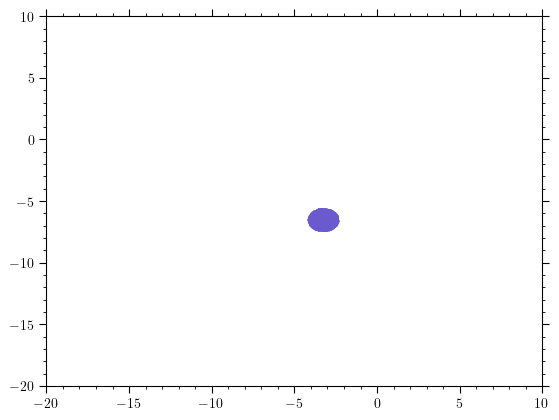

In [3]:
r_new = np.copy(r)
for i in range(5):
    clip = 3
    mean_ra = np.mean(r_new['pmra'])
    mean_dec = np.mean(r_new['pmdec'])
    vel = np.sqrt((r_new['pmra']-mean_ra)**2 + (r_new['pmdec']-mean_dec)**2)
    std_vel = np.std(vel, ddof=1)
    r_new = r_new[vel < clip*std_vel]
plt.plot(r_new['pmra'], r_new['pmdec'],'o', markersize=0.5, color='slateblue')
plt.xlim(-20, 10)
plt.ylim(-20, 10)

In [4]:
total_stars = len(r_new)
print('Total stars: {}'.format(total_stars))

Total stars: 5997


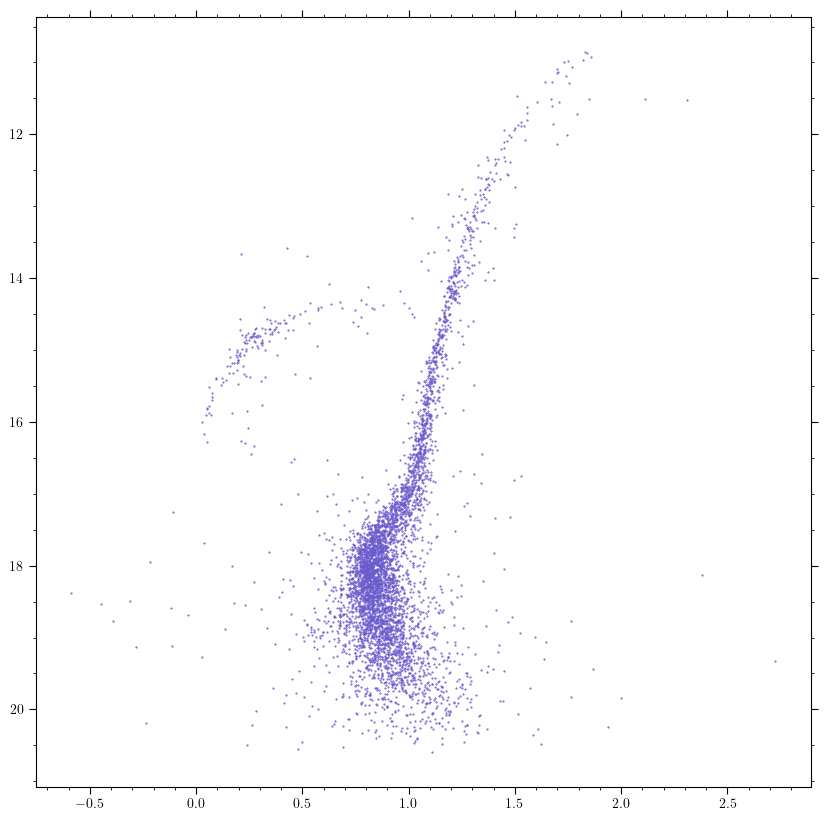

In [5]:
bprp = r_new['phot_bp_mean_mag'] - r_new['phot_rp_mean_mag']
g = r_new['phot_g_mean_mag']
g = g[~np.isnan(bprp)]
bprp = bprp[~np.isnan(bprp)]

plt.figure(figsize=(10,10))
plt.plot(bprp, g, 'o', markersize=0.5, color='slateblue')
plt.gca().invert_yaxis()

In [6]:
h_branch = g[np.where(np.logical_and(bprp <1 , bprp>0.6))]
h_branch = h_branch[np.where(h_branch < 15)]
print(np.mean(h_branch))

14.39708


Absolute Magnitude of Sun = $4.83$ 

Absolute Magnitude = $4.83 - 2.5 \log_{10} \left( \frac{L}{L_\odot} \right)$

Horizontal Branch stars have $L \approx 45L_\odot$

Absolute Magnitude of Horizontal Branch stars = $4.83 - 2.5 \log_{10} \left( \dfrac{45}{1} \right) =0.6969$

Distance Modulus = $m - M = 14.39708 - 0.6969 = 13.70018$

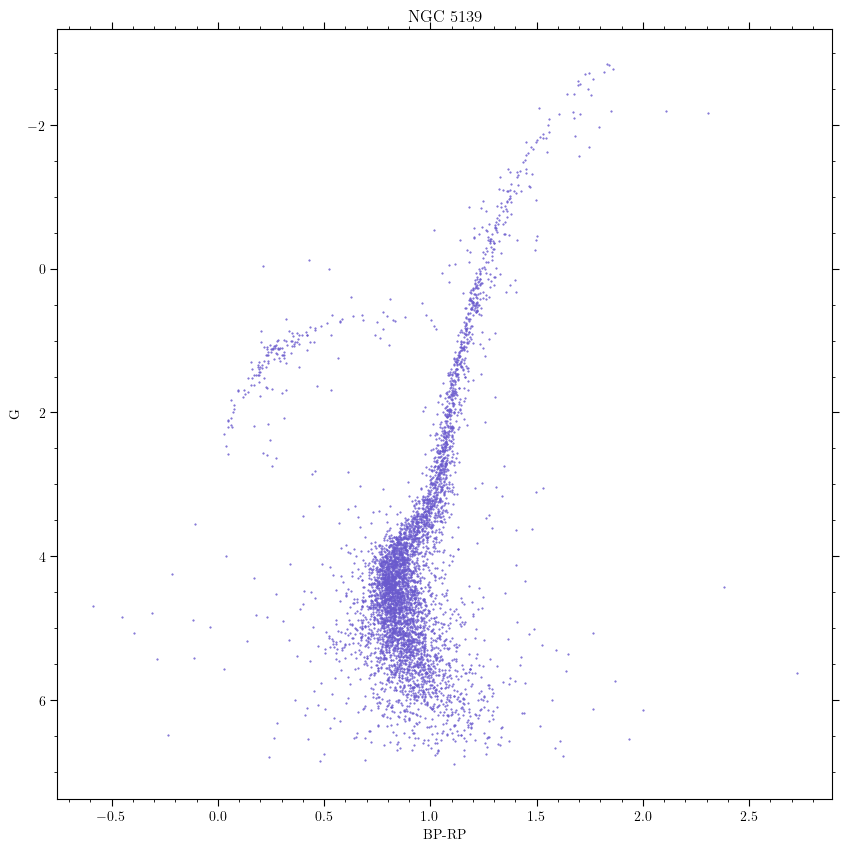

In [7]:
g_abs = g - 13.7
plt.figure(figsize=(10,10))
plt.plot(bprp, g_abs, 'o', markersize=0.5, color='slateblue')
plt.title('NGC 5139')
plt.xlabel('BP-RP')
plt.ylabel('G')
plt.gca().invert_yaxis()

### **Matching with theoretical isochrone**

In [8]:
# j=1
# while j <49:
#     for i in open('omega.dat', 'r').read().split("# "):
#         file = open(f'isochrone{j}.dat', 'w')
#         file.write(i)
#         file.close()
#         j+=1

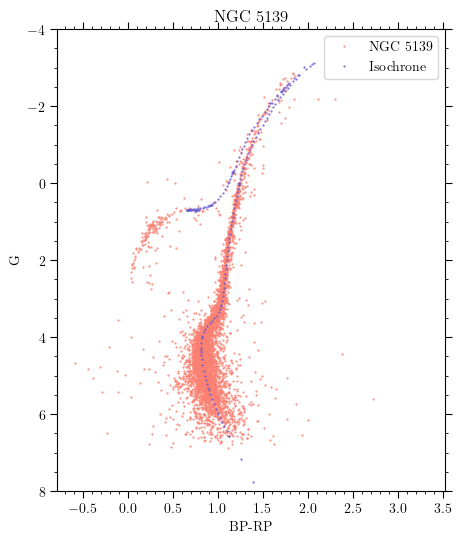

In [9]:
_, bprp_iso, g_iso, iso = f.sample_from_isochrone(isochrone_file='isochrone8.dat', plot=False, filter=False)
#shift the isochrone to account for scattering
g_iso = g_iso + 0.3
bprp_iso = bprp_iso + 0.18
plt.figure(figsize=(5,6))
plt.plot(bprp, g_abs, 'o', markersize=0.5, color='salmon', label='NGC 5139')
plt.plot(bprp_iso, g_iso, 'o', markersize=0.5, color='slateblue', label='Isochrone')
plt.ylim(-4,8)
plt.gca().invert_yaxis()
plt.xlabel('BP-RP')
plt.ylabel('G')
plt.legend()
plt.title('NGC 5139')
plt.show()

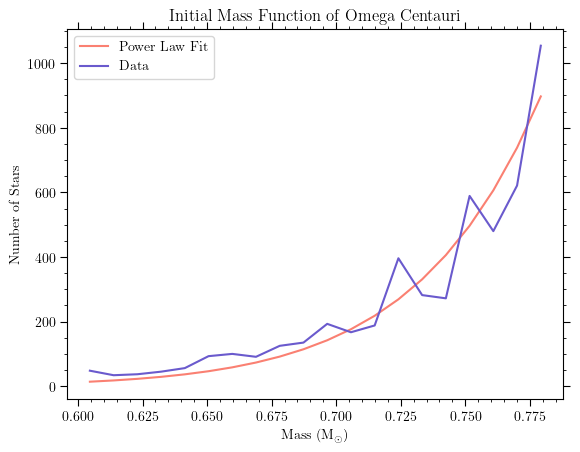

The power law index is -16.4124913312757


In [10]:
initial_mass = []

for b, absmag in zip(np.array(bprp), np.array(g_abs)):
    distance = np.sqrt((bprp_iso - b)**2 + (g_iso - absmag)**2)
    indices = np.where(distance == np.min(distance))[0][0]
    initial_mass.append(iso.iloc[indices]['Mini'])

n, bins = np.histogram(initial_mass, bins=20)
bins = (bins[1:] + bins[:-1])/2
popt, pcov = curve_fit(f.powerlaw, bins, n, p0=[1, 2])
plt.plot(bins, f.powerlaw(bins, *popt), label='Power Law Fit', color='salmon')
plt.plot(bins, n, label='Data', color='slateblue')
plt.ylabel('Number of Stars')
plt.xlabel('Mass (M$_\odot$)')
plt.title('Initial Mass Function of Omega Centauri')
plt.legend()
plt.show()
print('The power law index is', popt[1])